**Kaggle chinese recognition**

Public leaderboard (Accuracy) : 0.98558

In [0]:
!pip install tensorflow-gpu 

In [0]:
!pip install kaggle --upgrade

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.6)


In [0]:
import numpy as np
import tensorflow as tf
import pandas as pd

In [0]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
import os
os.environ['KAGGLE_USERNAME'] = "tselischevivaniad5" # username from the json file
os.environ['KAGGLE_KEY'] = # key from the json file

**Загрузка данных**

In [0]:
!kaggle competitions download -c chinese-char-recognition-smmo19

 96% 187M/195M [00:03<00:00, 56.4MB/s]
100% 195M/195M [00:03<00:00, 59.7MB/s]
 96% 108M/113M [00:01<00:00, 74.0MB/s] 
100% 113M/113M [00:01<00:00, 86.3MB/s]
 96% 159M/165M [00:01<00:00, 96.5MB/s]
100% 165M/165M [00:02<00:00, 83.5MB/s]
100% 202M/202M [00:00<00:00, 192MB/s]

  0% 0.00/965k [00:00<?, ?B/s]
100% 965k/965k [00:00<00:00, 134MB/s]
 92% 170M/185M [00:00<00:00, 168MB/s]
100% 185M/185M [00:00<00:00, 212MB/s]


In [0]:
!unzip \*.zip

Archive:  train-1.npy.zip
  inflating: train-1.npy             

Archive:  train-3.npy.zip
  inflating: train-3.npy             

Archive:  train-2.npy.zip
  inflating: train-2.npy             

Archive:  test.npy.zip
  inflating: test.npy                

Archive:  train-4.npy.zip
  inflating: train-4.npy             

5 archives were successfully processed.


In [0]:
data_test = np.load("./test.npy", allow_pickle=True)
data_test.shape

(83247,)

In [0]:
data_train = np.load("./train-1.npy", allow_pickle=True)
for i in range(2,5):
  t = np.load(f"./train-{i}.npy", allow_pickle=True)
  data_train = np.concatenate([data_train,t])

**Словари для Unicode-Id и Id-Unicode**

In [0]:
char_to_id = {label:int(idx) for idx,label in enumerate(np.unique(data_train[:,1]))}
id_to_char = {idx:label for label,idx in char_to_id.items()}

In [0]:
np.random.shuffle(data_train)

In [0]:
char_to_id[60100]

193

In [0]:
id_to_char[193]

60100

**Несколько иероглифов из трейна**

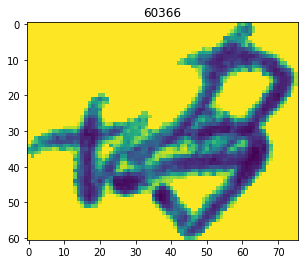

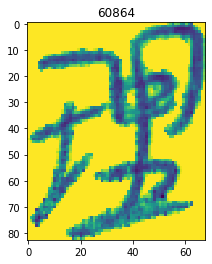

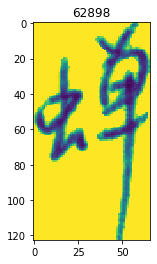

In [0]:
import matplotlib.pyplot as plt

for image, label in data_train[:3,:]:
  plt.figure()
  plt.imshow(image)
  plt.title(str(label))

**Preprocessing, generators**

In [0]:
val_size = 0.1
batch_size = 128

In [0]:
def train_gen():
  for img, label in data_train[int(len(data_train)*val_size):]:
    img = img[..., None]
    yield img, char_to_id[label]

In [0]:
IMG_SIZE = 64
def preprocess_train(image, label):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    label = tf.one_hot(label, 1000)
    return image, label

In [0]:
ds_train = tf.data.Dataset.from_generator(train_gen, output_types=(tf.float32, tf.int32), 
                                     output_shapes=((None, None, 1), ())).map(preprocess_train, num_parallel_calls=-1).prefetch(-1).shuffle(1024).batch(batch_size).repeat()

In [0]:
for im, val in ds_train.take(2):
  print(val)

tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(128, 1000), dtype=float32)
tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(128, 1000), dtype=float32)


In [0]:
def val_gen():
    for img, label in data_train[:int(len(data_train)*val_size)]:
      img = img[..., None]
      yield img, char_to_id[label]

In [0]:
def test_gen():
    for img in data_test:
      img = img[..., None]
      yield img

In [0]:
def preprocess_test(image):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image

In [0]:
ds_val = tf.data.Dataset.from_generator(val_gen, output_types=(tf.float32, tf.int32), 
                                     output_shapes=((None, None, 1), ())).map(preprocess_train, 
                                                                          num_parallel_calls=-1).prefetch(-1).shuffle(1024).batch(batch_size).repeat()

In [0]:
ds_test = tf.data.Dataset.from_generator(test_gen, output_types=(tf.float32), 
                                     output_shapes=(None, None, 1)).map(preprocess_test, 
                                                                          num_parallel_calls=-1).prefetch(-1).batch(batch_size)#.repeat()

**Модель и обучение**

In [0]:
def make_model2():    
    model2 = tf.keras.Sequential()

    model2.add(tf.keras.layers.Conv2D(filters=64, padding='same', kernel_size=(3,3), input_shape=(64,64,1), kernel_initializer=tf.keras.initializers.lecun_uniform()))
    model2.add(tf.keras.layers.LeakyReLU(0.1))
    model2.add(tf.keras.layers.Conv2D(filters=64, padding='same', kernel_size=(3,3), kernel_initializer=tf.keras.initializers.lecun_uniform())) 
    model2.add(tf.keras.layers.LeakyReLU(0.1))
    model2.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), padding='same'))
    model2.add(tf.keras.layers.Dropout(0.2))

    model2.add(tf.keras.layers.Conv2D(filters=128, padding='same', kernel_size=(3,3), kernel_initializer=tf.keras.initializers.lecun_uniform()))
    model2.add(tf.keras.layers.LeakyReLU(0.1))
    model2.add(tf.keras.layers.Conv2D(filters=128, padding='same', kernel_size=(3,3), kernel_initializer=tf.keras.initializers.lecun_uniform()))
    model2.add(tf.keras.layers.LeakyReLU(0.1))
    model2.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), padding='same'))
    model2.add(tf.keras.layers.Dropout(0.2))

    model2.add(tf.keras.layers.Conv2D(filters=256, padding='same', kernel_size=(3,3), kernel_initializer=tf.keras.initializers.lecun_uniform()))
    model2.add(tf.keras.layers.LeakyReLU(0.1))
    model2.add(tf.keras.layers.Conv2D(filters=256, padding='same', kernel_size=(3,3), kernel_initializer=tf.keras.initializers.lecun_uniform()))
    model2.add(tf.keras.layers.LeakyReLU(0.1))
    model2.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), padding='same'))
    model2.add(tf.keras.layers.Dropout(0.3))

    model2.add(tf.keras.layers.Conv2D(filters=512, padding='same', kernel_size=(3,3), kernel_initializer=tf.keras.initializers.lecun_uniform()))
    model2.add(tf.keras.layers.LeakyReLU(0.1))
    model2.add(tf.keras.layers.Conv2D(filters=512, padding='same', kernel_size=(3,3), kernel_initializer=tf.keras.initializers.lecun_uniform()))
    model2.add(tf.keras.layers.LeakyReLU(0.1))
    model2.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), padding='same'))
    model2.add(tf.keras.layers.Dropout(0.4))

    model2.add(tf.keras.layers.Flatten())
    model2.add(tf.keras.layers.Dense(1024, kernel_initializer=tf.keras.initializers.lecun_uniform()))               
    model2.add(tf.keras.layers.LeakyReLU(0.1))
    model2.add(tf.keras.layers.Dropout(0.5))  
    model2.add(tf.keras.layers.Dense(1024, kernel_initializer=tf.keras.initializers.lecun_uniform()))                
    model2.add(tf.keras.layers.LeakyReLU(0.1))
    model2.add(tf.keras.layers.Dropout(0.5))
    model2.add(tf.keras.layers.Dense(1000, kernel_initializer=tf.keras.initializers.lecun_uniform()))   
    model2.add(tf.keras.layers.Activation('softmax'))          
    return model2

In [0]:
EPOCHS = 22
INIT_LR = 5e-3#INIT_LR = 0.001
model2 = make_model2()
model2.summary()
model2.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adamax(learning_rate=INIT_LR),
    metrics=['categorical_accuracy']
)
def lr_scheduler(epoch):
    return INIT_LR * 0.9 ** epoch

model2.fit(
    ds_train,
    epochs=EPOCHS,
    callbacks=[
               tf.keras.callbacks.LearningRateScheduler(lr_scheduler),
               tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
              ],
    validation_data=ds_val,
    validation_steps=200,
    steps_per_epoch=2000
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       7

**Предсказание и сабмит**

In [0]:
y_pred2 = model2.predict(ds_test)
y_pred2 = y_pred2.argmax(-1)
y_pred2 = [id_to_char[c] for c in y_pred2]
csv2 = pd.read_csv('./random_labels.csv')
csv2['Category'] = y_pred2
csv2.to_csv("submission4.csv", index=False)

In [0]:
csv2.shape

(83247, 2)

In [0]:
!kaggle competitions submit -c chinese-char-recognition-smmo19 -f submission4.csv -m "Submission4"

100% 965k/965k [00:02<00:00, 426kB/s]
Successfully submitted to Chinese character recognition